In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
import os

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from pipeline.preprocessing import load_spacy_model
from pipeline.preprocessing.vectorize import EventVectoriser

# Data

In [4]:
# load data from file
datadir = os.path.join('data','classification')  # change this if stored else

#filenames = [os.path.basename(file) for file in os.listdir(datadir)]  # get all files in path

filenames = ['events_high-conf.csv','events_medium-conf.csv','events_low-conf.csv']

filepaths = [os.path.join(datadir, filename) for filename in filenames]

In [5]:
# load specific spacy model
nlp = load_spacy_model(output_type='text', lemmatizer=True, geological_matcher=False, stopword_removal=False,
                       punctuation_removal=True, lemmatize_triggers=True, verbose=False)

# specify columns to load from data
usecols = ['event_id','filename','anumber','sentence_count','report_type','sentence_idx','sentence_triggers',
           'event_text','label','lower_idx','upper_idx']

# load dataframes into dictionary where key is filename
data = {filename : pd.read_csv(filepath, usecols=usecols) for filename, filepath in zip(filenames, filepaths)}

# pipe all datasets through nlp model to get text tokens
for filename in filenames:
    data[filename]['tokens'] = [tokens for tokens in tqdm(
        nlp.pipe(data[filename].event_text.values), desc=f'Tokenising {filename} text')]

# get class proportions for each labelled data set
def get_class_balances(data):
    class_balance = pd.concat([data[filename].label.value_counts().to_frame().rename(
        columns={'label':filename}).T for filename in data.keys()])

    return class_balance.div(class_balance.sum(axis=1), axis=0)

display(get_class_balances(data))

Tokenising events_high-conf.csv text: 1212it [00:11, 108.31it/s]
Tokenising events_medium-conf.csv text: 1212it [00:09, 133.11it/s]
Tokenising events_low-conf.csv text: 1212it [00:08, 139.30it/s]


,False,True
events_high-conf.csv,0.939769,0.060231
events_medium-conf.csv,0.849010,0.150990
events_low-conf.csv,0.771452,0.228548


# Vectorisation

In [6]:
# vectorisation settings to experiment with
vec_size = 20 # set number of dimensions for our numerical vectorisations by all methods
min_count = 1  # set minimum frequency for a word to be included in the training vocab, else remove

In [7]:
# vectorizers
vectorizers = {
    'doc2vec': EventVectoriser(num_workers=6, min_count=min_count, vec_size=vec_size),
    'lsa': Pipeline([
        ('tfidf', TfidfVectorizer(min_df=min_count, sublinear_tf=True)),
        ('svd', TruncatedSVD(n_components=vec_size))])
}

vectors = {
    key :  # for each data file
        { filename :   # for each type of vectoriser
         
             # doc2vec needs a pair of ids and list of tokenised strings - returns df by default
             vectorizer.fit_transform(data_df[['event_id','tokens']]) if key == 'doc2vec' else 
         
             # LSA needs a sentence as a string, but we tokenise first with spacy (data.tokens)
             pd.DataFrame(
                 vectorizer.fit_transform(data_df['tokens'].apply(lambda tokens : ' '.join(tokens).strip())),
                 index=data_df['event_id']
             )
            
        for filename, data_df in data.items()}
    for key, vectorizer in vectorizers.items()
}

# display preview of df
for v in vectorizers:
    for f in filenames:
        print(f'filename: {filename} vectorizer: {v}')
        display(vectors[v][f].head(3))
        print('')

filename: events_low-conf.csv vectorizer: doc2vec


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
event_id,,,,,,,,,,,,,,,,,,,,
a071816_apollo 2005 annual tech report_11275634_186,-0.309702,-0.015381,1.865729,3.333165,-1.693082,0.340323,-0.009704,-1.832001,-1.470716,1.401524,-2.764750,2.452268,-0.430920,0.246836,1.546085,2.043405,2.453022,-2.181370,-3.917408,-0.448055
a071875_700-100-go-rep-0002_13675165_172,0.409230,-0.889789,-0.087555,3.041629,-1.554118,-4.231331,0.491391,-2.184334,-3.401244,3.195414,-0.765910,1.886571,-3.341596,-2.271554,-0.701780,-0.390025,0.983514,2.666140,0.466412,-0.775742
a071950_c591_1994_2005a_16001655_730,4.351756,-0.673725,-1.322009,3.140911,1.718558,0.018396,3.858104,-5.044916,-1.848122,3.510566,-2.883783,2.444237,4.104649,-1.285299,0.846973,0.227512,-3.337893,3.281751,-1.972041,-2.688559



filename: events_low-conf.csv vectorizer: doc2vec


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
event_id,,,,,,,,,,,,,,,,,,,,
a071816_apollo 2005 annual tech report_11275634_186,0.373415,-0.446899,1.019670,3.917551,-0.868973,-1.925702,-1.905906,0.469356,-2.523401,1.441709,-1.518296,2.842904,0.127014,0.241772,0.362113,1.047516,1.338940,-2.449016,-3.555747,-2.039755
a071875_700-100-go-rep-0002_13675165_172,2.987029,-1.294351,-0.343540,0.959077,-1.947722,-2.279819,0.815332,-1.539081,-1.854350,4.041904,-2.313349,1.954972,-3.583845,-2.107422,-0.067282,-0.905519,0.640573,2.624683,0.021004,-0.218352
a071950_c591_1994_2005a_16001655_730,1.398500,-0.505971,-3.778647,3.021411,1.577506,-0.178180,2.630653,-2.557776,-4.345374,2.259830,-0.757792,3.041085,3.907686,-1.129797,-1.416607,0.895188,-1.004917,4.652929,-2.699712,-3.492830



filename: events_low-conf.csv vectorizer: doc2vec


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
event_id,,,,,,,,,,,,,,,,,,,,
a071816_apollo 2005 annual tech report_11275634_186,-0.395919,-1.382835,2.001570,3.664697,-1.073102,0.373971,-1.317153,0.568154,-1.923752,0.473034,-2.858938,2.718381,0.915308,0.451275,0.611125,1.455443,3.151778,-0.829446,-3.392815,-0.613388
a071875_700-100-go-rep-0002_13675165_172,1.539870,-2.379633,0.150012,0.806880,-1.450486,-2.585273,0.792045,-3.077763,-2.190210,3.445037,-4.085876,1.362390,-2.572187,-2.190808,-1.078239,-1.289088,-0.196396,3.253221,-0.202609,0.108280
a071950_c591_1994_2005a_16001655_730,2.866099,-1.544649,-2.238369,2.374297,1.201597,-2.189459,1.237235,-2.078674,-4.975244,2.036996,-2.274722,1.877447,7.471082,-0.374342,0.065029,1.809148,-3.518461,2.455597,-1.637977,-1.806414



filename: events_low-conf.csv vectorizer: lsa


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
event_id,,,,,,,,,,,,,,,,,,,,
a071816_apollo 2005 annual tech report_11275634_186,0.294631,-0.048543,0.225185,-0.036524,-0.052063,0.032447,-0.023748,-0.115143,0.006519,0.066442,0.022416,0.015127,0.034311,-0.021997,-0.042091,0.032232,0.064096,-0.020213,-0.000167,0.030139
a071875_700-100-go-rep-0002_13675165_172,0.268296,0.037437,0.021151,-0.025799,0.022377,0.035511,-0.026053,-0.126694,0.016623,0.017617,0.017250,-0.035121,0.033147,0.055793,0.021017,0.020029,-0.047100,0.024140,0.047594,0.004245
a071950_c591_1994_2005a_16001655_730,0.230275,-0.053386,0.006624,-0.058331,0.193269,0.088479,0.024076,0.118577,-0.099444,0.010770,0.083375,0.016364,0.144325,0.151742,-0.057570,-0.108639,-0.001904,-0.086263,-0.022321,0.076868



filename: events_low-conf.csv vectorizer: lsa


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
event_id,,,,,,,,,,,,,,,,,,,,
a071816_apollo 2005 annual tech report_11275634_186,0.297632,-0.050881,0.225683,-0.042975,-0.060342,0.020716,0.000918,-0.116421,0.008651,0.069391,-0.018674,-0.006625,0.051735,-0.006641,-0.009998,0.003545,-0.065331,0.035162,-0.012803,-0.087708
a071875_700-100-go-rep-0002_13675165_172,0.270876,0.035564,0.019524,-0.030382,0.017956,0.037509,0.018412,-0.132760,0.002487,0.000956,-0.010817,0.032414,-0.009320,0.066681,0.033391,0.033772,0.067368,0.039664,-0.030974,-0.007201
a071950_c591_1994_2005a_16001655_730,0.232874,-0.060385,0.013000,-0.047784,0.194051,0.093001,0.046452,0.116933,-0.077526,-0.008571,-0.064197,0.070352,0.094840,0.145168,0.032002,-0.039238,-0.044467,-0.114563,-0.037284,-0.070280



filename: events_low-conf.csv vectorizer: lsa


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
event_id,,,,,,,,,,,,,,,,,,,,
a071816_apollo 2005 annual tech report_11275634_186,0.301031,-0.049935,0.234599,-0.051554,-0.068957,0.001620,0.018473,-0.114590,0.036289,0.082654,0.036363,-0.024703,-0.055899,-0.011922,0.013774,-0.031470,0.051570,-0.002755,0.006175,-0.087078
a071875_700-100-go-rep-0002_13675165_172,0.272362,0.038462,0.021112,-0.026893,0.016126,-0.010590,0.023653,-0.132479,0.009613,-0.005588,-0.000887,-0.002036,-0.022196,-0.036003,-0.056224,-0.039692,-0.071761,0.003696,0.034855,-0.043063
a071950_c591_1994_2005a_16001655_730,0.233873,-0.059814,0.010342,-0.042972,0.183634,-0.034516,0.081533,0.099071,-0.099431,0.012861,0.151304,-0.052143,-0.111891,-0.105373,-0.083720,0.124343,0.066351,0.074405,-0.029177,-0.015353


# Classification

## Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

# prepare dictionaries to store labels and ids for each data file
train_ids, train_labels, test_ids, test_labels = {}, {}, {}, {}

# for filename in data
for fn in data.keys():
    train_ids[fn], test_ids[fn], train_labels[fn], test_labels[fn] = train_test_split(
        data[fn].event_id, data[fn].label.to_frame().set_index(data[fn].event_id),
        test_size=0.2, stratify=data[fn].label, random_state=888)
    
# build train and test split
train = { method:  # train is a dictionary of vectors based on [method][filename] keys, and df values
    {filename : vector_df.loc[train_ids[filename].values]  # for each fil for each fn
     for filename, vector_df in vector_dfs.items()} # process each file's dataframe of word embeddings (vectors)
         for method, vector_dfs in vectors.items()}  # for each vectorisation method

# test is same as train code, but with the test_ids event_id strings for each file
test = { method: {filename : vector_df.loc[test_ids[filename].values]
    for filename, vector_df in vector_dfs.items()} for method, vector_dfs in vectors.items()}

# Specify Example Dataset for Classification

In [9]:
# example - model selection process should include all and store results in dataframe
example_dataset = 'events_medium-conf.csv'
train['doc2vec'][example_dataset]

X_train_vec = train['doc2vec'][example_dataset]
X_test_vec = test['doc2vec'][example_dataset]

y_train = train_labels[example_dataset].values.reshape(-1)
y_test = test_labels[example_dataset].values.reshape(-1)

## CosineMeanClassifier

In [10]:
from pipeline.classify import CosineMeanClassifier
from sklearn import metrics

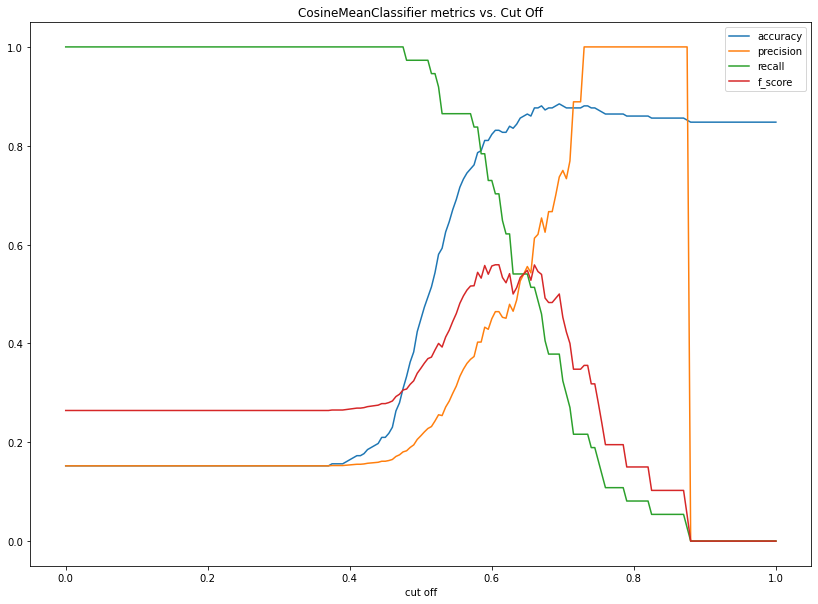

In [11]:
cutoffs = np.linspace(0., 1.0, 201)
result_data = []

for cutoff in cutoffs:
    clf = CosineMeanClassifier(cutoff=cutoff)
    clf = clf.fit(train['doc2vec'][example_dataset])
    y_pred = clf.predict(test['doc2vec'][example_dataset])
    result_data.append({
        'accuracy': metrics.accuracy_score(test_labels[example_dataset], y_pred),
        'precision' : metrics.precision_score(test_labels[example_dataset], y_pred, zero_division=0),
        'recall' : metrics.recall_score(test_labels[example_dataset], y_pred, zero_division=0),
        'f_score' : metrics.f1_score(test_labels[example_dataset], y_pred, zero_division=0)
    })
    
results = pd.DataFrame(result_data, index=cutoffs)
results.plot(figsize=(14,10), title='CosineMeanClassifier metrics vs. Cut Off', xlabel='cut off');

# Explainability with SHAP

In [12]:
from xgboost import XGBClassifier
from yellowbrick.classifier import (
    classification_report, confusion_matrix, class_prediction_error, class_balance, roc_auc
)

In [13]:
model = XGBClassifier(nestimators=100, max_depth=2).fit(train['doc2vec'][example_dataset], train_labels[example_dataset])

[15:05:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { nestimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [14]:
X_train_vec = train['doc2vec'][example_dataset]
X_test_vec = test['doc2vec'][example_dataset]

y_train = train_labels[example_dataset].values.reshape(-1)
y_test = test_labels[example_dataset].values.reshape(-1)

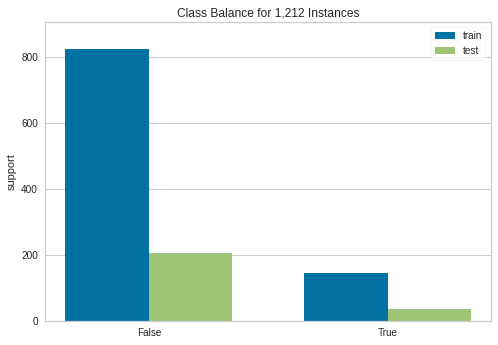

In [15]:
class_balance(y_train, y_test);

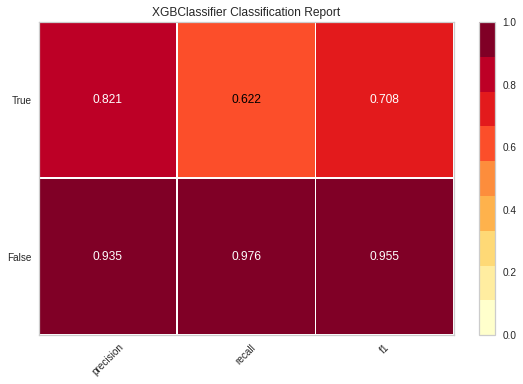

In [16]:
classification_report(model, X_train_vec, y_train, X_test_vec, y_test);

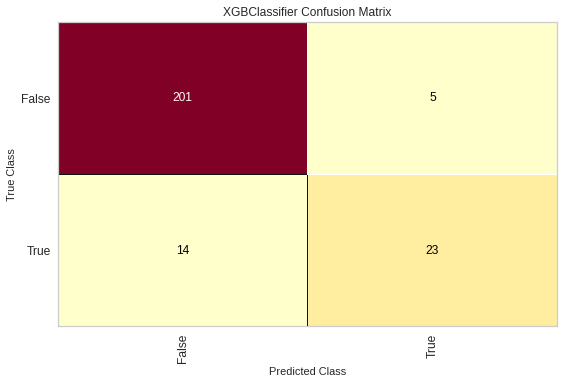

In [17]:
confusion_matrix(model, X_train_vec, y_train, X_test_vec, y_test);

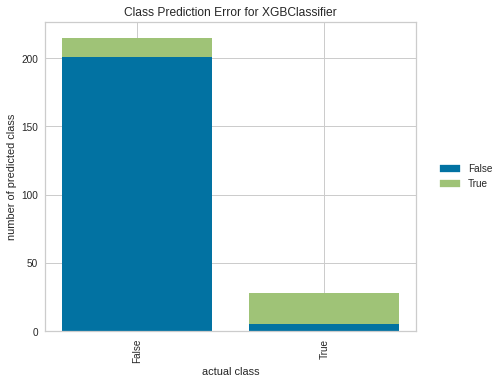

In [18]:
class_prediction_error(model, X_train_vec, y_train, X_test_vec, y_test);

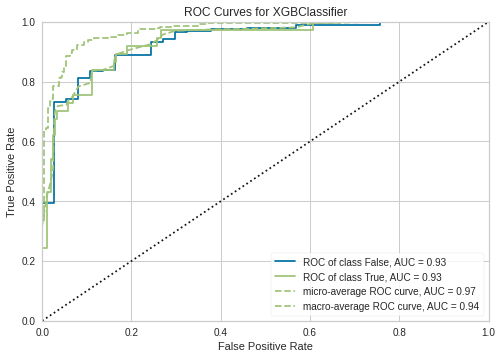

In [19]:
roc_auc(model, X_train_vec, y_train, X_test_vec, y_test);

In [20]:
import shap
shap.initjs()

In [21]:
vector_list, label_list = [], []
vec_model = vectorizers['doc2vec'].model
for word in vec_model.wv.vocab:
    vector_list.append(vec_model.wv[word])
    label_list.append(word)
    
exp_labels = np.array(label_list)

In [22]:
explainer = shap.Explainer(model, train['doc2vec'][example_dataset])http://localhost:8888/tree